In [4]:
import pandas as pd

dataset = pd.read_csv('data/UNBC/list/final_3/UNBC_disfa_labelled_intensity.csv')
dataset.head()

,image_path,pspi,AU1,AU2,AU04,AU06,AU09,AU12,AU25,AU26
0,064-ak064/ak064t1aaaff/001.png,0,0,0,0,0,0,0,0,0
1,064-ak064/ak064t1aaaff/002.png,0,0,0,0,0,0,0,0,0
2,064-ak064/ak064t1aaaff/003.png,0,0,0,0,0,0,0,0,0
3,064-ak064/ak064t1aaaff/004.png,0,0,0,0,0,0,0,0,0
4,064-ak064/ak064t1aaaff/005.png,0,0,0,0,0,0,0,0,0


In [21]:
from model.ANFL import FullPictureMEFARGVisualize
from utils import load_state_dict

def load_sft_model():
    model = FullPictureMEFARGVisualize(
        num_classes=8,
        backbone='resnet50',
        neighbor_num=3,
    )
    model = load_state_dict(model, "./results/final/full_bs_64_seed_0_lr_0.0001/epoch8_model_fold1.pth")
    model.eval()
    return model

def load_no_pretrain_model():
    model = FullPictureMEFARGVisualize(
        num_classes=10,
        backbone='resnet50',
        neighbor_num=4,
    )
    model = load_state_dict(model, "./results/final/no_pretrain_bs_64_seed_0_lr_0.0001/epoch8_model_fold1.pth")
    model.eval()
    return model


100%|██████████| 100/100 [00:05<00:00, 16.90it/s]


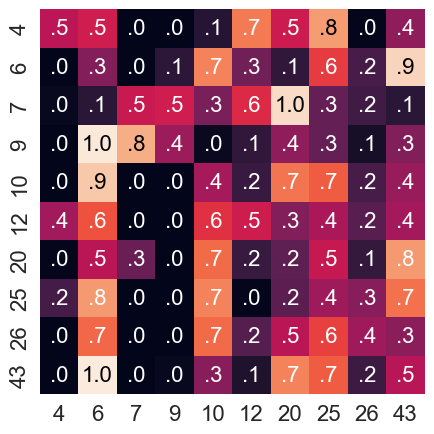

100%|██████████| 100/100 [00:06<00:00, 16.26it/s]


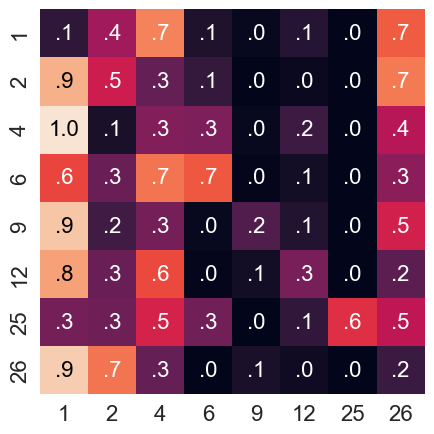

100%|██████████| 100/100 [00:05<00:00, 17.42it/s]


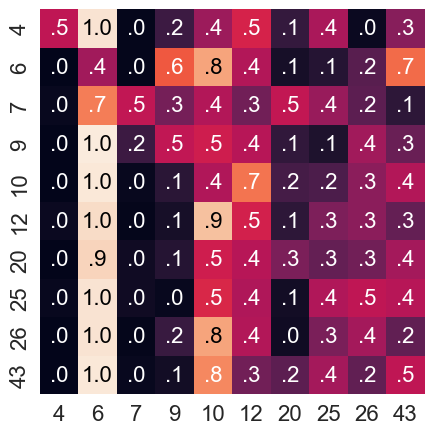

100%|██████████| 100/100 [00:05<00:00, 19.36it/s]


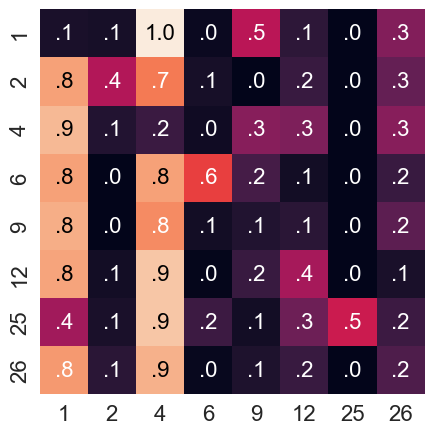

In [38]:
from tqdm import tqdm
import torch
from PIL import Image
from torchvision import transforms
from dataset import default_loader

import seaborn as sns
import matplotlib.pyplot as plt

# 11	1	1	4	3	3	3	0	0


def run_model(model, sample_image_paths):
    adjs = []
    aus = []
    predictions = []

    for sample_image_path in tqdm(sample_image_paths):
        sample_image_path = f'data/UNBC/img/{sample_image_path}'
        image = default_loader(sample_image_path)
        transform = transforms.Compose([
            transforms.ToTensor()
        ])
        sample_image = transform(image).unsqueeze(0)
        cl, au, pe, bb, bb_au, adj = model(sample_image)
        cl = torch.softmax(cl, dim=1)
        predictions.append(cl)
        adjs.append(adj)
        aus.append(au)

    avg_pred = torch.stack(predictions).mean(dim=0)
    avg_adj = torch.stack(adjs).mean(dim=0)
    avg_au = torch.stack(aus).mean(dim=0)

    return avg_pred, avg_adj, avg_au

def visualize_au_edge_heatmap(au_info, au_names):
    # Visualize `bb_au` tensor as a heatmap
    heatmap_data = au_info.detach().numpy().astype(float)  # Convert tensor to numpy for plotting
    plt.figure(figsize=(6, 5))  # Set figure size
    sns.heatmap(
        heatmap_data,
        annot=False,
        fmt=".1f",  # Format annotations, suppress leading 0 in decimals
        cmap="rocket",
        vmax=1,
        vmin=0,
        xticklabels=[name.strip('AU') for name in au_names],  # Remove "AU" prefix
        yticklabels=[name.strip('AU') for name in au_names],  # Remove "AU" prefix
        cbar=False,
        square=True,
        annot_kws={"size": 14}  # Make heatmap annotation font larger
    )
    for i in range(heatmap_data.shape[0]):
        for j in range(heatmap_data.shape[1]):
            plt.text(
                j + 0.5,
                i + 0.5,
                f"{heatmap_data[i, j]:.1f}".lstrip("0"),  # Remove leading zero
                ha="center",
                va="center",
                fontsize=16,
                color='black' if heatmap_data[i, j] >= 0.8 else 'white'
            )
    plt.xticks(fontsize=16)  # Make x-axis label font larger
    plt.yticks(fontsize=16)  # Make y-axis label font larger
    plt.show()  # Display the heatmap

def test_models(models, sample_image_paths):
    for model in models:
        avg_pred, avg_adj, avg_au = run_model(model, sample_image_paths)

        au_num = avg_au.shape[-1]
        if au_num == 8:
            au_names = ['AU1', 'AU2', 'AU4', 'AU6', 'AU9', 'AU12', 'AU25', 'AU26']
        else:
            au_names = ['AU4', 'AU6', 'AU7', 'AU9', 'AU10', 'AU12', 'AU20', 'AU25', 'AU26', 'AU43']
        au_info = avg_adj - torch.eye(au_num) + torch.eye(au_num) * avg_au
        au_info = torch.clamp(au_info, min=0)
        au_info = au_info.view(au_num, au_num)
        visualize_au_edge_heatmap(au_info, au_names)

models = [load_no_pretrain_model(), load_sft_model()]
sample_num = 100
sample_image_paths = dataset[dataset['pspi'] > 4].sample(sample_num)['image_path'].tolist()
test_models(models, sample_image_paths)
sample_image_paths = dataset[dataset['pspi'] == 0].sample(sample_num)['image_path'].tolist()
test_models(models, sample_image_paths)